# Physical attacks - Detection

## I - Modules

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score,recall_score,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## II - Charger donnée

Utilisons donnée préparée :

In [2]:
df_normal = pd.read_csv("preparation/physical_normal.csv")
df_attack_1 = pd.read_csv("preparation/physical_1.csv")
df_attack_2 = pd.read_csv("preparation/physical_2.csv")
df_attack_3 = pd.read_csv("preparation/physical_3.csv")
df_attack_4 = pd.read_csv("preparation/physical_4.csv")

In [3]:
concat_df_paths = ["preparation/physical/all_data_concat/all_data_concat_full_size.csv",
                   "preparation/physical/all_data_concat/all_data_concat_divided_by_10.csv",
                   "preparation/physical/all_data_concat/all_data_concat_divided_by_100.csv",               
                   ]
concat_df_name = ["full_size","divided_by_10", "divided_by_100"]

df_concat_div_10 = pd.read_csv("preparation/physical/all_data_concat/all_data_concat_divided_by_10.csv")
df_concat_div_100 = pd.read_csv("preparation/physical/all_data_concat/all_data_concat_divided_by_100.csv")
df_concat_full = pd.read_csv("preparation/physical/all_data_concat/all_data_concat_full_size.csv")

df_concat_list = [df_concat_full, df_concat_div_10, df_concat_div_100]

## III - Fonctions

### 0 - Fonction d'évaluation et matrice de confusion

In [4]:
# Definitions générales

dict_label_string_to_int = {'normal': 0, 'MITM': 1, 'physical fault': 2, 'scan': 3, 'DoS': 4}
dict_label_int_to_string = {0: 'normal', 1: 'MITM', 2: 'physical fault', 3: 'scan', 4: 'DoS'}

metrics_list = ['precision', 'recall', 'TPR', 'TNR', 'accuracy', 'F1-score', 'balanced_accuracy', 'Matthews_Correlation_Coefficient']
labels_list = ['DoS', 'MITM', 'normal', 'physical fault', 'scan']
model_list = ['KNN', 'MLP', 'SVM', 'RF', 'CART', 'XGBoost']
data_size_list = ['full', '/10', '/100']

index_df_physical_metrics = pd.MultiIndex.from_product([model_list, data_size_list, labels_list, metrics_list], names=['Model', 'Data Size', 'Attack', 'Metric'])

# C'est dans cet objet que l'on va ranger toutes les métriques de physical
df_physical_metrics = pd.DataFrame(columns=['Value'], index=index_df_physical_metrics)


In [13]:
def plot_confusion_matrix(y_preds, y_true, labels, conf_mat_name, model_name, save_cof_mat=False,):
    cm = confusion_matrix(y_true, y_preds,normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    
    if model_name == "Random_forest":
        int_labels = labels.tolist()
        labels_for_fig = []

        for int_label in int_labels:
            labels_for_fig.append(dict_label_int_to_string[int_label])
        
    else:
        labels_for_fig = [(l[0:4] if isinstance(l, str) else str(l)) for l in labels]


    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels_for_fig)

    disp.plot(cmap="Blues", values_format="4f", ax=ax, colorbar=False)
    
    
    try:
        #disp.plot(cmap="Blues", values_format="4f", ax=ax, colorbar=False)
        folder_path= f"./images/physical/Results/{model_name}/Confusion_matrix/"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        if save_cof_mat:
            plt.savefig(f"./images/physical/Results/{model_name}/Confusion_matrix/{conf_mat_name}.png")
    except:
        print("ERREUR MATRICE DE CONFUSION")
        print(pd.unique(y_preds))
        print(pd.unique(y_true))
        print(labels)
        
    plt.title(conf_mat_name)
    plt.show()



def eval_model(y_pred, y_test, labels, conf_mat_name, model_name, save_cof_mat=False):

    

    if model_name == "Random_forest":
        int_labels = labels.tolist()
        labels_for_fig = []

        for int_label in int_labels:
            labels_for_fig.append(dict_label_int_to_string[int_label])
        
    else:
        # Check if labels is already a list, if not, convert it
        labels_for_fig = labels if isinstance(labels, list) else labels.tolist()


    #labels_for_fig = list(set(labels_for_fig))  # Keep only unique values in the list
    

    #plot_confusion_matrix(list(y_pred), list(y_test), labels_for_fig, conf_mat_name, model_name, save_cof_mat,)


    metric_tab = classification_report(y_test, y_pred)

    # print(classification_report(y_test, y_pred))
    
    # Print the confusion matrix directly
    cm = confusion_matrix(y_test, y_pred, labels=labels)


    index_df_model_size = pd.MultiIndex.from_product([labels_list, metrics_list], names=['Attack', 'Metric'])
    df_model_size = pd.DataFrame(columns=['Value'], index=index_df_model_size).fillna(0)
    
    # Compute and print metrics for each class
    for i, label in enumerate(labels_for_fig):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        tnr = tn / (tn + fp)  # True negative rate
        tpr = tp / (tp + fn)  # True positive rate
        fnr = fn / (fn + tp)  # False negative rate
        fpr = fp / (fp + tn)  # False positive rate


        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        

        # Pour chaque métrique, assignez la valeur correspondante dans le DataFrame
        df_model_size.at[(label, 'precision'), 'Value'] = precision
        df_model_size.at[(label, 'recall'), 'Value'] = recall
        df_model_size.at[(label, 'TPR'), 'Value'] = tpr
        df_model_size.at[(label, 'TNR'), 'Value'] = tnr
        df_model_size.at[(label, 'accuracy'), 'Value'] = (tp + tn) / (tp + tn + fp + fn)
        df_model_size.at[(label, 'F1-score'), 'Value'] = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        df_model_size.at[(label, 'balanced_accuracy'), 'Value'] = (tpr + tnr) / 2
        df_model_size.at[(label, 'Matthews_Correlation_Coefficient'), 'Value'] = mcc


        

        # basic_metric_df[[('col1val1','col2val1'), ('col1val2','col2val2')]]
    
        # print(label)
        # print("tp", tp)
        # print("fp", fp)
        # print("fn", fn)
        # print("tn", tn)
        # print("\n")
        
        

        
        
        # print(f"\nMetrics for class {label}:")
        # print(f"True negative rate: {tnr:.4f}")
        # print(f"True positive rate: {tpr:.4f}")
        # print(f"False negative rate: {fnr:.4f}")
        # print(f"False positive rate: {fpr:.4f}")


        
    
    return df_model_size
    
    
    

### 2 - KNN

In [6]:
def KNN_attack_detection(df, name_df="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # k autour de 10 (à tester)
    k = 10

    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)


    y_pred = knn_model.predict(X_test)
    df_model_size = eval_model(y_pred, y_test, knn_model.classes_, name_df, "KNN", True)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

    return df_model_size

### 3 - Random Forest

In [7]:
def randomForest_attack_detector(df, name_df="xxx"):
    new_df = df.copy()
    
    new_df["Label"] = new_df["Label"].map(dict_label_string_to_int)
    
    X = new_df.drop('Label', axis=1)  # Features
    y = new_df['Label']  # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    rf = RandomForestClassifier(n_estimators=20, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    df_model_size = eval_model(y_pred, y_test, rf.classes_, name_df, "Random_forest", True)

    return df_model_size
    

### 4 - MLP

In [8]:
def MLP_attack_detector(df, name_df="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    clf = MLPClassifier(random_state=1, max_iter=300)
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    df_model_size = eval_model(y_pred, y_test, clf.classes_, name_df,  "MLP", True)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

    return df_model_size
    

### 5 - SVM

In [9]:
def SVM_attack_detector(df, name_df="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    df_model_size = eval_model(y_pred, y_test, clf.classes_, name_df, "SVM", True)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

    return df_model_size

### 6) CART

In [10]:
def CART_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    clf = DecisionTreeClassifier(random_state=1)
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)
    df_model_size = eval_model(y_pred, y_test, clf.classes_, True, "CART", model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

    return df_model_size

### 7) XGBoost

In [11]:
def XGB_attack_detector(df, name_df="xxx", model_name="xxx"):
    new_df = df.copy()
    print("taille",len(df))
    

    n=0
    labels = pd.unique(new_df["Label"])
    mapping = {}
    for label in labels:
        mapping[label] = n
        n += 1

    new_df["Label"] = new_df["Label"].map(mapping)

    
    X = new_df.drop('Label', axis=1)  # Caractéristiques
    y = new_df['Label']  # Cible
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


    xgb_model = xgb.XGBClassifier(objective="reg:linear", random_state=42)

    xgb_model.fit(X_train, y_train)


    y_pred = xgb_model.predict(X_test)
    df_model_size = eval_model(y_pred, y_test, list(range(n)), True, "XGBoost", model_name)
    #print("Précision du modèle KNN : {:.2f}%".format(accuracy * 100))
    #plot_confusion_matrix(list(y_pred),list(y_test),knn_model.classes_)

    return df_model_size

## IV - Detection

In [11]:
# dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
# dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

# i=0
# for df in dataframes:
#     print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
#     KNN_attack_detection(df, dataframes_name[i] + "_conf_mat", "KNN")
#     i+=1

In [17]:
# KNN_attack_detection(pd.concat([df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attacks_conf_mat", "KNN")

# for paths in concat_df_paths:
#     print("\n\n\033[1;33m" + paths + "\033[0m")
#     df = pd.read_csv(paths)

#     conf_mat_name = "physical " + os.path.basename(paths)
    

#     KNN_attack_detection(df, conf_mat_name, "KNN")

In [14]:
# KNN_attack_detection(pd.concat([df_normal,df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attack_&_normal_conf_mat", "KNN")

index = pd.MultiIndex.from_product([data_size_list, labels_list, metrics_list], names=['Data Size', 'Attack', 'Metric'])
df_KNN_metrics = pd.DataFrame(columns=['Value'], index=index)
df_Random_forest_metrics = pd.DataFrame(columns=['Value'], index=index)
df_MLP_metrics = pd.DataFrame(columns=['Value'], index=index)
df_SVM_metrics = pd.DataFrame(columns=['Value'], index=index)
df_CART_metrics = pd.DataFrame(columns=['Value'], index=index)
df_XGBoost_metrics = pd.DataFrame(columns=['Value'], index=index)

i = 0
for data_size, df in zip(data_size_list, df_concat_list):

    df_model_size_KNN = KNN_attack_detection(df, concat_df_name[i])
    df_model_size_Random_forest = randomForest_attack_detector(df, concat_df_name[i])
    df_model_size_MLP = MLP_attack_detector(df, concat_df_name[i])
    df_model_size_SVM = SVM_attack_detector(df, concat_df_name[i])
    df_model_size_CART = CART_attack_detector(df, concat_df_name[i])
    df_model_size_XGBoost = XGB_attack_detector(df, concat_df_name[i])
    
    i+=1

    # Iterate through each label and metric in df_model_size
    for label in labels_list:
        for metric in metrics_list:
            # Get the value from df_model_size and assign it to df_KNN_metrics
            value = df_model_size_KNN.at[(label, metric), 'Value']
            df_KNN_metrics.at[(data_size, label, metric), 'Value'] = value

            value = df_model_size_Random_forest.at[(label, metric), 'Value']
            df_Random_forest_metrics.at[(data_size, label, metric), 'Value'] = value

            value = df_model_size_MLP.at[(label, metric), 'Value']
            df_MLP_metrics.at[(data_size, label, metric), 'Value'] = value

            value = df_model_size_SVM.at[(label, metric), 'Value']
            df_SVM_metrics.at[(data_size, label, metric), 'Value'] = value

            value = df_model_size_CART.at[(label, metric), 'Value']
            df_CART_metrics.at[(data_size, label, metric), 'Value'] = value

            value = df_model_size_XGBoost.at[(label, metric), 'Value']
            df_XGBoost_metrics.at[(data_size, label, metric), 'Value'] = value
    

# Iterate through the MultiIndex of df_physical_metrics
for index in df_physical_metrics.index:
    model, data_size, label, metric = index

    # Check if the current row corresponds to the 'KNN' model
    if model == 'KNN':
        value = df_KNN_metrics.at[(data_size, label, metric), 'Value']
        df_physical_metrics.at[(model, data_size, label, metric), 'Value'] = value

    if model == '"Random_forest':
        value = df_model_size_Random_forest.at[(data_size, label, metric), 'Value']
        df_physical_metrics.at[(model, data_size, label, metric), 'Value'] = value
    
    if model == 'MLP':
        value = df_MLP_metrics.at[(data_size, label, metric), 'Value']
        df_physical_metrics.at[(model, data_size, label, metric), 'Value'] = value

    if model == 'SVM':
        value = df_SVM_metrics.at[(data_size, label, metric), 'Value']
        df_physical_metrics.at[(model, data_size, label, metric), 'Value'] = value

    if model == 'CART':
        value = df_CART_metrics.at[(data_size, label, metric), 'Value']
        df_physical_metrics.at[(model, data_size, label, metric), 'Value'] = value

    if model == 'XGBoost':
        value = df_XGBoost_metrics.at[(data_size, label, metric), 'Value']
        df_physical_metrics.at[(model, data_size, label, metric), 'Value'] = value
    
    

taille 10923


/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orfeu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_97071/461998053.py:86: Ru

taille 10923


### 3 - Random Forest

In [63]:
# dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
# dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

# i=0
# for df in dataframes:
#     print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
#     randomForest_attack_detector(df, dataframes_name[i] + "_conf_mat")
#     i+=1

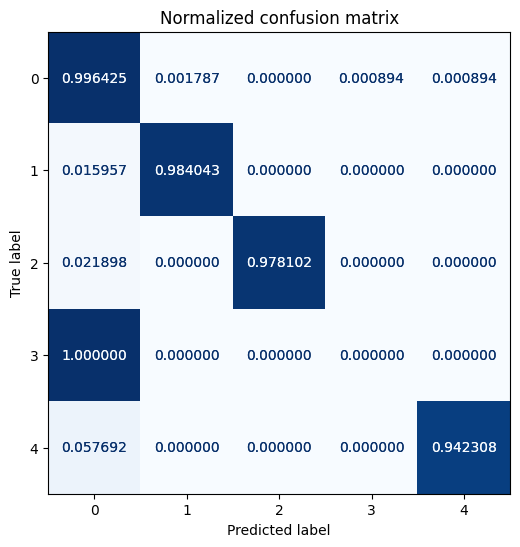

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1119
           1       0.99      0.98      0.99       188
           2       1.00      0.98      0.99       137
           3       0.00      0.00      0.00         3
           4       0.98      0.94      0.96        52

    accuracy                           0.99      1499
   macro avg       0.79      0.78      0.79      1499
weighted avg       0.99      0.99      0.99      1499


Metrics for class 0:
True negative rate: 0.9684
True positive rate: 0.9964
False negative rate: 0.0036
False positive rate: 0.0316

Metrics for class 1:
True negative rate: 0.9985
True positive rate: 0.9840
False negative rate: 0.0160
False positive rate: 0.0015

Metrics for class 2:
True negative rate: 1.0000
True positive rate: 0.9781
False negative rate: 0.0219
False positive rate: 0.0000

Metrics for class 3:
True negative rate: 0.9993
True positive rate: 0.0000
False negative rate: 1.0000
False posit

In [62]:
randomForest_attack_detector(pd.concat([df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attack_conf_mat", "Random_forest")

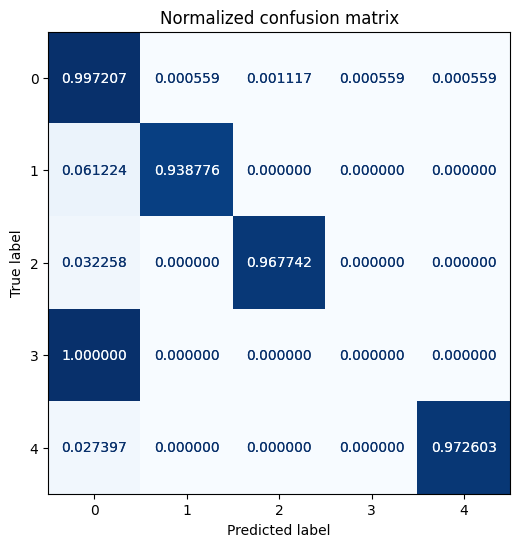

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1790
           1       0.99      0.94      0.97       196
           2       0.98      0.97      0.98       124
           3       0.00      0.00      0.00         2
           4       0.99      0.97      0.98        73

    accuracy                           0.99      2185
   macro avg       0.79      0.78      0.78      2185
weighted avg       0.99      0.99      0.99      2185


Metrics for class 0:
True negative rate: 0.9494
True positive rate: 0.9972
False negative rate: 0.0028
False positive rate: 0.0506

Metrics for class 1:
True negative rate: 0.9995
True positive rate: 0.9388
False negative rate: 0.0612
False positive rate: 0.0005

Metrics for class 2:
True negative rate: 0.9990
True positive rate: 0.9677
False negative rate: 0.0323
False positive rate: 0.0010

Metrics for class 3:
True negative rate: 0.9995
True positive rate: 0.0000
False negative rate: 1.0000
False posit

In [63]:
randomForest_attack_detector(pd.concat([df_normal,df_attack_1,df_attack_2,df_attack_3,df_attack_4]), "all_attack_&_normal_conf_mat", "Random_forest")

In [64]:
np.round([5.8,7,2.2])

array([6., 7., 2.])

### 3 - MLP



df_attack_1
taille 2420


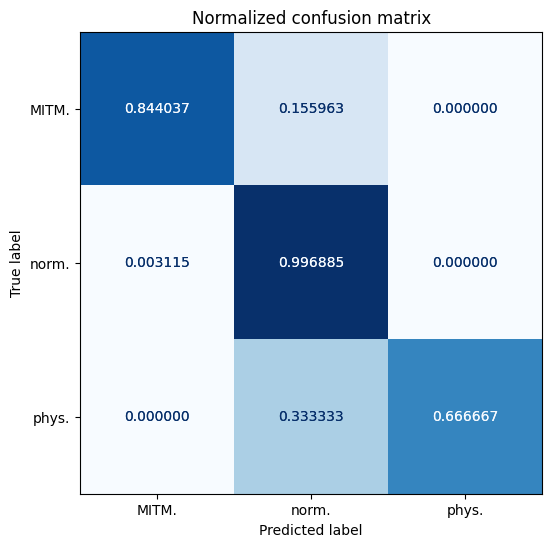

                precision    recall  f1-score   support

          MITM       0.99      0.84      0.91       109
        normal       0.90      1.00      0.95       321
physical fault       1.00      0.67      0.80        54

      accuracy                           0.93       484
     macro avg       0.96      0.84      0.89       484
  weighted avg       0.93      0.93      0.92       484


Metrics for class MITM:
True negative rate: 0.9973
True positive rate: 0.8440
False negative rate: 0.1560
False positive rate: 0.0027

Metrics for class normal:
True negative rate: 0.7853
True positive rate: 0.9969
False negative rate: 0.0031
False positive rate: 0.2147

Metrics for class physical fault:
True negative rate: 1.0000
True positive rate: 0.6667
False negative rate: 0.3333
False positive rate: 0.0000


df_attack_2
taille 2104


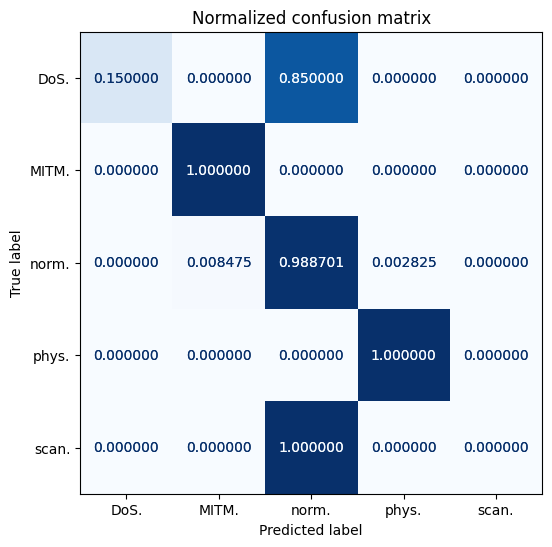

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

                precision    recall  f1-score   support

           DoS       1.00      0.15      0.26        20
          MITM       0.84      1.00      0.91        16
        normal       0.95      0.99      0.97       354
physical fault       0.97      1.00      0.98        30
          scan       0.00      0.00      0.00         1

      accuracy                           0.95       421
     macro avg       0.75      0.63      0.63       421
  weighted avg       0.95      0.95      0.93       421


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.1500
False negative rate: 0.8500
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9926
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0074

Metrics for class normal:
True negative rate: 0.7313
True positive rate: 0.9887
False negative rate: 0.0113
False positive rate: 0.2687

Metrics for class physical fault:
True negative rate: 0.9974
True positive rate: 1.000

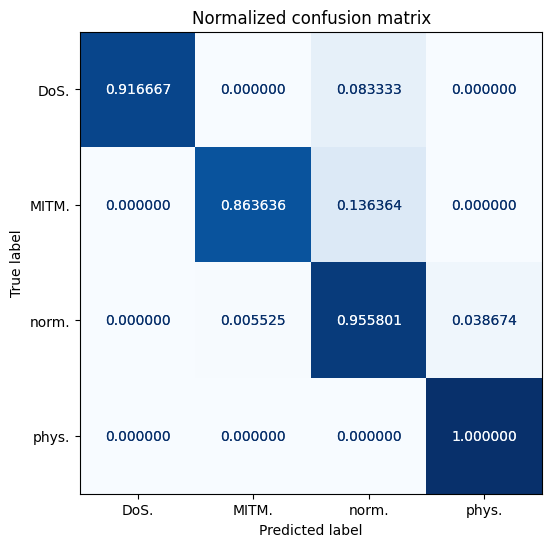

                precision    recall  f1-score   support

           DoS       1.00      0.92      0.96        12
          MITM       0.95      0.86      0.90        22
        normal       0.98      0.96      0.97       181
physical fault       0.84      1.00      0.91        36

      accuracy                           0.95       251
     macro avg       0.94      0.93      0.93       251
  weighted avg       0.96      0.95      0.95       251


Metrics for class DoS:
True negative rate: 1.0000
True positive rate: 0.9167
False negative rate: 0.0833
False positive rate: 0.0000

Metrics for class MITM:
True negative rate: 0.9956
True positive rate: 0.8636
False negative rate: 0.1364
False positive rate: 0.0044

Metrics for class normal:
True negative rate: 0.9429
True positive rate: 0.9558
False negative rate: 0.0442
False positive rate: 0.0571

Metrics for class physical fault:
True negative rate: 0.9674
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.032

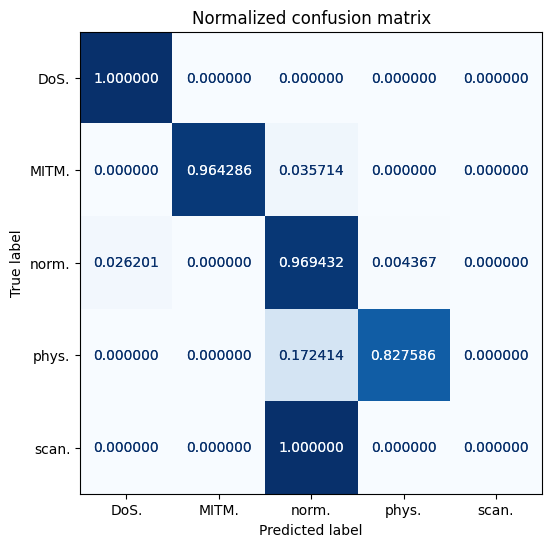

                precision    recall  f1-score   support

           DoS       0.83      1.00      0.91        29
          MITM       1.00      0.96      0.98        56
        normal       0.97      0.97      0.97       229
physical fault       0.96      0.83      0.89        29
          scan       0.00      0.00      0.00         1

      accuracy                           0.96       344
     macro avg       0.75      0.75      0.75       344
  weighted avg       0.96      0.96      0.96       344


Metrics for class DoS:
True negative rate: 0.9810
True positive rate: 1.0000
False negative rate: 0.0000
False positive rate: 0.0190

Metrics for class MITM:
True negative rate: 1.0000
True positive rate: 0.9643
False negative rate: 0.0357
False positive rate: 0.0000

Metrics for class normal:
True negative rate: 0.9304
True positive rate: 0.9694
False negative rate: 0.0306
False positive rate: 0.0696

Metrics for class physical fault:
True negative rate: 0.9968
True positive rate: 0.827

c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nikko\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [10]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    MLP_attack_detector(df, dataframes_name[i] + "_conf_mat", "MLP")
    i+=1

### 4 - SVM

In [2]:
dataframes = [df_attack_1, df_attack_2, df_attack_3, df_attack_4]
dataframes_name = ['df_attack_1', 'df_attack_2', 'df_attack_3', 'df_attack_4']

i=0
for df in dataframes:
    print("\n\n\033[1;33m" + dataframes_name[i] + "\033[0m")
    SVM_attack_detector(df, dataframes_name[i] + "_conf_mat", "SVM")
    i+=1

NameError: name 'df_attack_1' is not defined